# Imports

In [1]:
import torch
from captum.attr import LayerLRP
from captum.attr._utils.lrp_rules import EpsilonRule, Alpha1_Beta0_Rule
from torchvision.models.feature_extraction import create_feature_extractor

# Custom imports
from models import AudioNet, VIL_Model
from methods import preprocess_audio, get_audio, plot_and_play, reshape_tensor, predict_instance, plot_data, plot_relevancy, prepare_for_plotting
from virtual_inspection_layers import DFT_Layer, IDFT_Layer, STDFT_Layer, ISTDFT_Layer, DCT_Layer, IDCT_Layer, DWT_Layer, IDWT_Layer

# Implementing XAI to explain model prediction for a single audio instance
### Basic setup: Load pre-trained model

In [2]:
### Load pre-trained model ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AudioNet().to(device)  # Initialize the model
model.load_state_dict(torch.load('model_weights.pth', map_location=device)) # Add pre-trained weights

<All keys matched successfully>

### Get single Audio for Classification and LRP

Digit: 8
Speaker: 17
Recording: 22
Audio File Path: AudioMNIST/data/17/8_17_22.wav


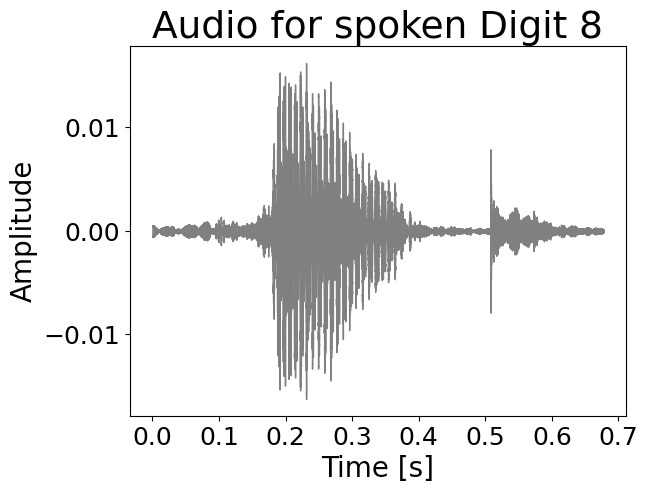

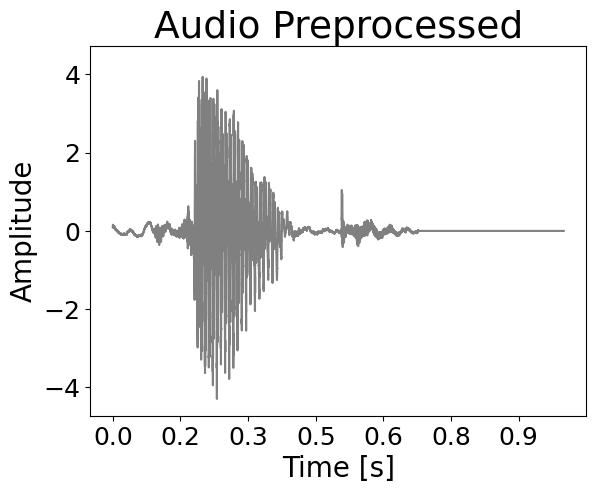

In [3]:
# Choose audio or use None for random
digit = None # 0-9
speaker = None # 1-60
recording = None # 0-49

# Get random audio sample
audio, sample_rate, audio_file_path, digit = get_audio(digit=digit, speaker=speaker, recording=recording)

# Preprocess audio data and convert to PyTorch tensor
audio_preprocessed = preprocess_audio(audio.requires_grad_(True), sample_rate, fixed_offset=True)

include_digit_in_title = True
if include_digit_in_title:
    plot_and_play(f"Audio for spoken Digit {digit}", prepare_for_plotting(audio), sample_rate=sample_rate)
else:
    plot_and_play("Audio for spoken Digit", prepare_for_plotting(audio), sample_rate=sample_rate)
plot_and_play("Audio Preprocessed", prepare_for_plotting(audio_preprocessed))

# Layer-wise Relevancy Propagation (LRP) for desired transformation

In [4]:
# Decide on the transformation (Conv, DFT, STDFT, DCT, DWT)
transformation = 'DWT'

if transformation == 'Conv': # Conv describes the original model without VIL layers
    model.eval()
else:
    transform_layer = globals()[f'{transformation}_Layer']()
    invert_transform_layer = globals()[f'I{transformation}_Layer']()
    
    # "Attach" transformation layers to create virtual inspection layer model
    vil_model = VIL_Model(model, transform_layer, invert_transform_layer)
    vil_model.eval()

Prediction:  8
End index is beyond the maximum of 1004. Resetting to the maximum.


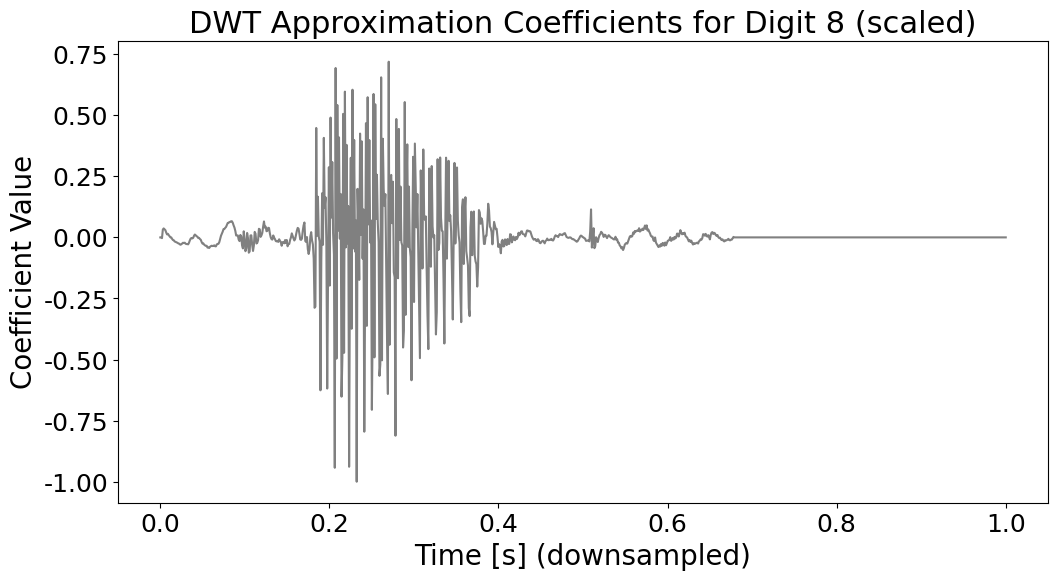

End index is beyond the maximum of 1004. Resetting to the maximum.


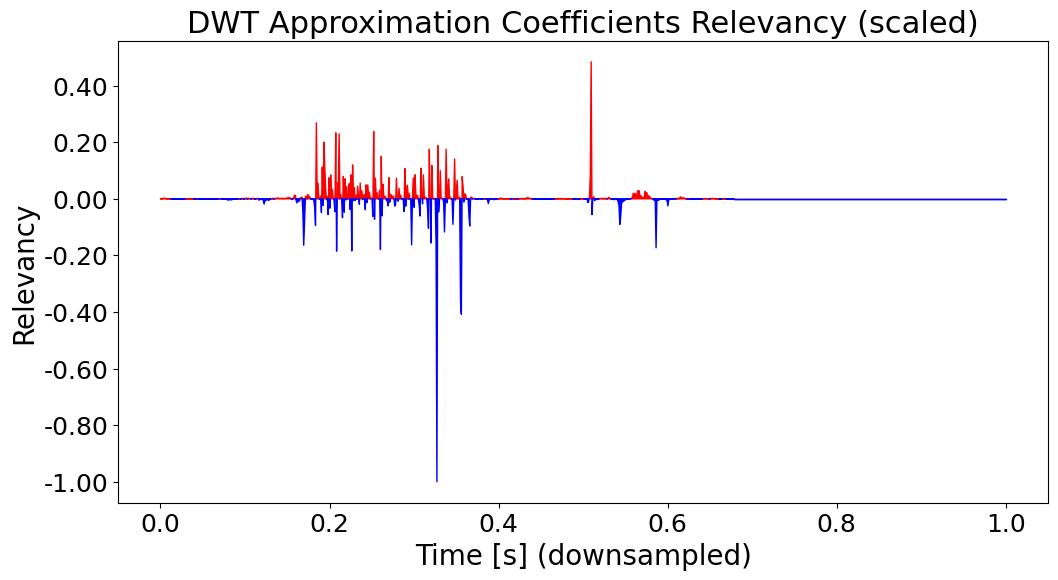

In [5]:
epsilon = 0.01

if transformation == 'Conv':
    ### Rules implemented like Vielhaben et al. ###
    model.conv1.rule = Alpha1_Beta0_Rule() # Equivalent to z+ rule (only positive values considered)
    model.conv2.rule = Alpha1_Beta0_Rule()
    model.conv3.rule = Alpha1_Beta0_Rule()
    model.conv4.rule = Alpha1_Beta0_Rule()
    model.conv5.rule = Alpha1_Beta0_Rule()
    model.conv6.rule = Alpha1_Beta0_Rule()
    model.fc7.rule = EpsilonRule(epsilon=epsilon) # Prevent division by zero through small offset
    model.fc8.rule = EpsilonRule(epsilon=epsilon)
    model.fc9.rule = EpsilonRule(epsilon=epsilon)

else: # Virtual inspection layer models
    ### Feel free to experiment with different rules here ###
    vil_model.transform_layer.rule = EpsilonRule(epsilon=epsilon)
    vil_model.invert_transform_layer.rule = EpsilonRule(epsilon=epsilon)

    ### Rules implemented like Vielhaben et al. ###
    vil_model.existing_model.conv1.rule = Alpha1_Beta0_Rule()
    vil_model.existing_model.conv2.rule = Alpha1_Beta0_Rule()
    vil_model.existing_model.conv3.rule = Alpha1_Beta0_Rule()
    vil_model.existing_model.conv4.rule = Alpha1_Beta0_Rule()
    vil_model.existing_model.conv5.rule = Alpha1_Beta0_Rule()
    vil_model.existing_model.conv6.rule = Alpha1_Beta0_Rule()
    vil_model.existing_model.fc7.rule = EpsilonRule(epsilon=epsilon)
    vil_model.existing_model.fc8.rule = EpsilonRule(epsilon=epsilon)
    vil_model.existing_model.fc9.rule = EpsilonRule(epsilon=epsilon)

# Perform LRP on desired layer
if transformation == 'Conv':
    layer = model.conv1
    lrp = LayerLRP(model, layer)
    audio_tensor_reshaped = reshape_tensor(audio_preprocessed)  # Add batch and chanel dimensions: [8000] -> [1, 1, 8000]
    
    prediction = predict_instance(model, audio_tensor_reshaped)
    print("Prediction: ", prediction)
    
    # Extract output of conv1 layer
    feature_extractor = create_feature_extractor(model, {'conv1': 'conv1_output'})
    with torch.no_grad():
        features = feature_extractor(audio_tensor_reshaped)
    data = features['conv1_output'].squeeze() # Remove dimension -> [100, 8000]
    
else:
    layer = vil_model.transform_layer
    lrp = LayerLRP(vil_model, layer)
    audio_tensor_reshaped = audio_preprocessed.unsqueeze(0)  # Add batch dimension -> [1, 8000] 
    
    prediction = predict_instance(vil_model, audio_tensor_reshaped)
    print("Prediction: ", prediction)
    
    # Extract reconstructed audio for verification
    with torch.no_grad():
        vil_model(audio_tensor_reshaped) # pass input through model
        reconstructed_audio = vil_model.reconstructed_audio
        
    data = audio_preprocessed    
    
attr = lrp.attribute(audio_tensor_reshaped, target=prediction)

# Adjust index as needed (does not work for STDFT)
# For Conv and DWT, start_index must be 0 (logic for custom start index will be implemented in a future version)
start_index = 0 # min is 0
end_index = 8000 # max is 8000 (1004 for DWT), which equals the length of the transformed audio

plot_data(transformation=transformation, data=data, digit=digit, scale=True, magnitudes=False, start_index=start_index, end_index=end_index)
plot_relevancy(transformation=transformation, attr=attr, digit=None, start_index=start_index, end_index=end_index)

 # Optional: Validate correct transformation and inversion
## Validation 1: Audibly compare original preprocessed and reconstructed preprocessed audio

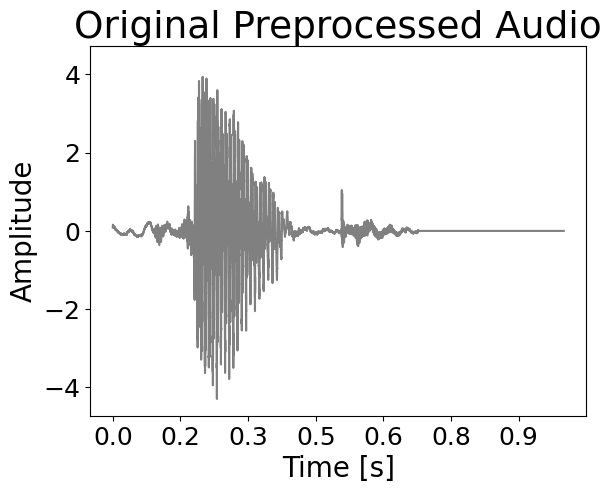

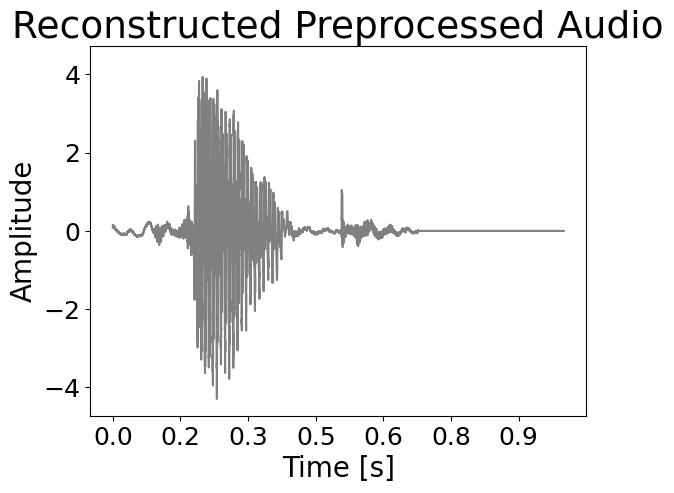

In [6]:
if transformation != 'Conv':
    plot_and_play("Original Preprocessed Audio", prepare_for_plotting(audio_preprocessed))
    plot_and_play("Reconstructed Preprocessed Audio", prepare_for_plotting(reconstructed_audio))

# Validation 2: Compare VIL model performance(s) to original model

Accuracy for 3000 predictions by original model (without VIL): 0.9893333333333333
Accuracy for 3000 predictions by DWT VIL model: 0.9893333333333333
Accuracy for 3000 predictions by DFT VIL model: 0.9893333333333333
Accuracy for 3000 predictions by DCT VIL model: 0.9893333333333333
Accuracy for 3000 predictions by STDFT VIL model: 0.9556666666666667


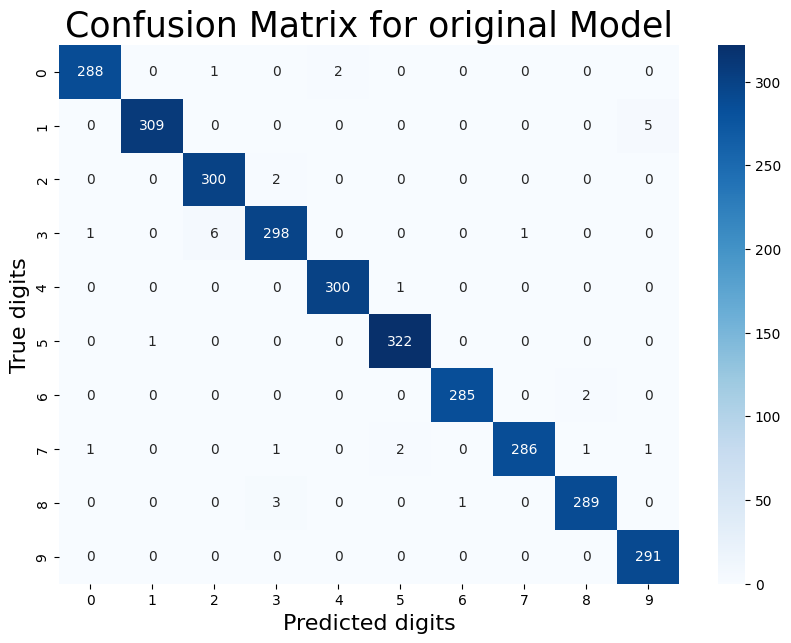

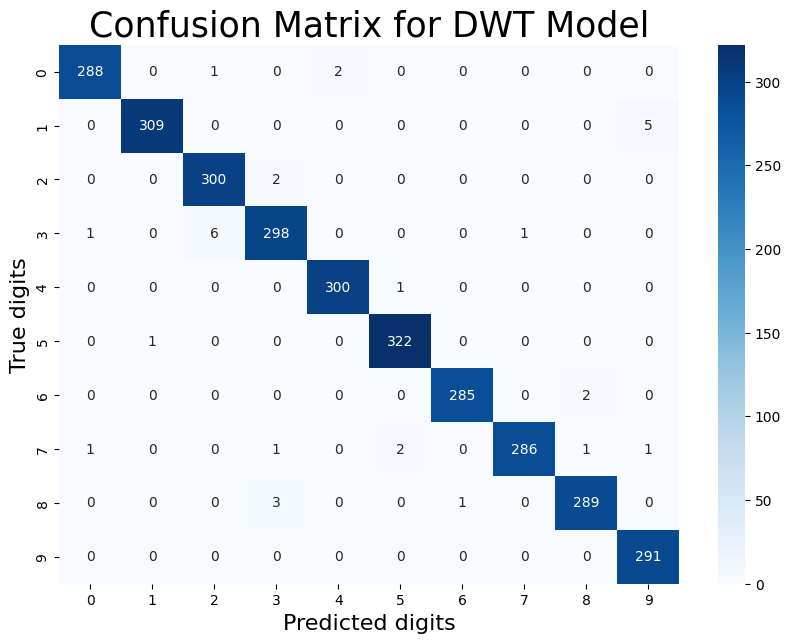

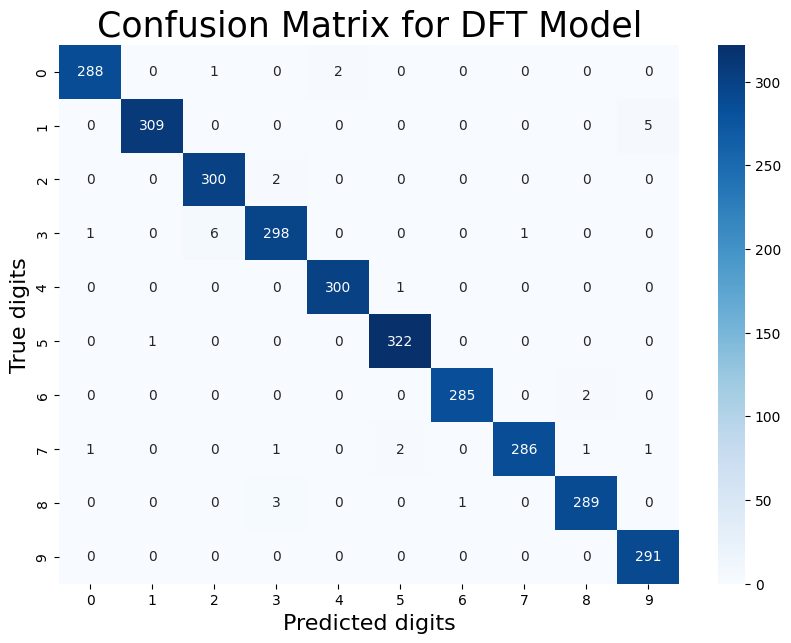

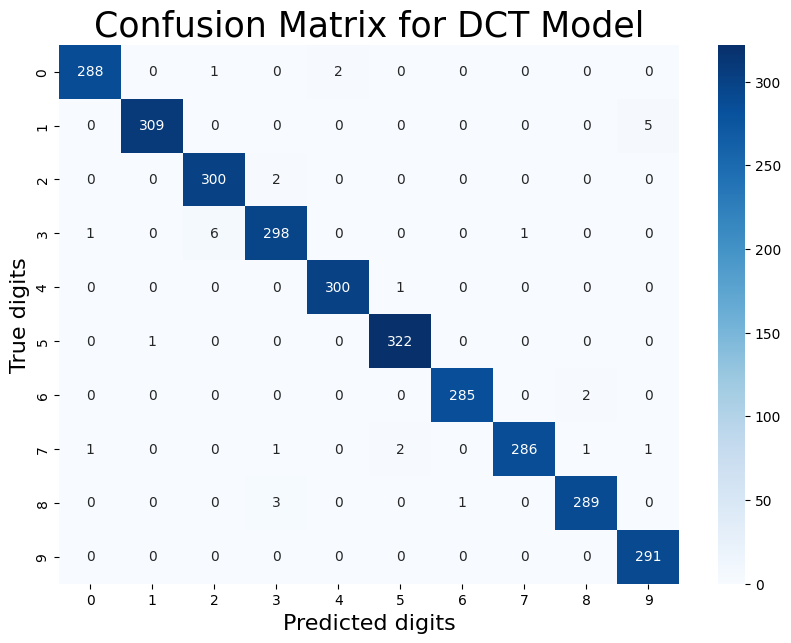

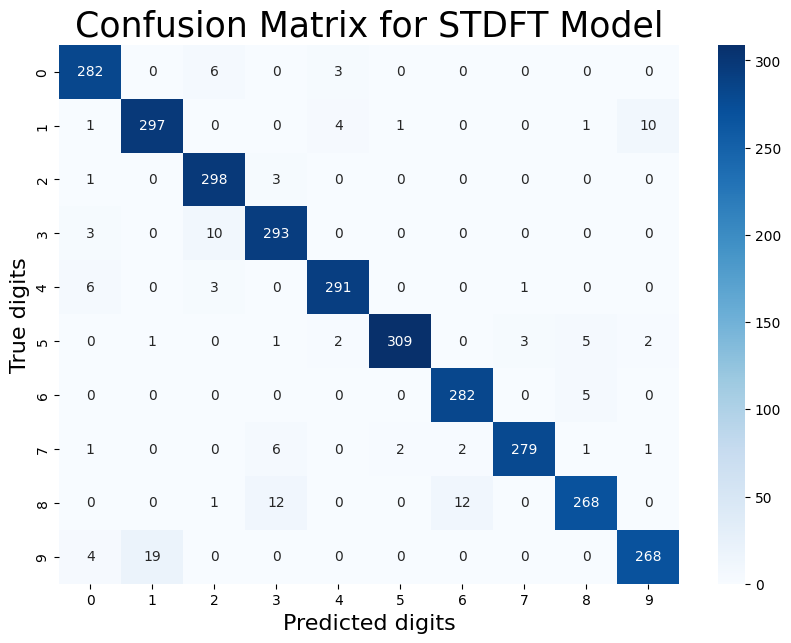

In [36]:
from torch import nn
from methods import evaluate, create_confusion_matrix

# Setup evaluation
transformations = ['Conv', 'DWT', 'DFT', 'DCT', 'STDFT']
criterion = nn.CrossEntropyLoss()
batch_size = 1
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cm = True

# Prepare test data
test_data = torch.load('test_data.pt')
test_labels = torch.load('test_labels.pt')

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate model(s)
for transformation in transformations:
    # Model setup
    model = AudioNet().to(device)  # Initialize
    model.load_state_dict(torch.load('model_weights.pth', map_location=device)) # Add pre-trained weights
    
    if transformation != 'Conv': # VIL models
        transform_layer = globals()[f'{transformation}_Layer']()
        invert_transform_layer = globals()[f'I{transformation}_Layer']()
        
        model = VIL_Model(model, transform_layer, invert_transform_layer)
        
    _, accuracy, true_labels, predictions = evaluate(model, criterion, test_data, test_labels, batch_size, device, transformation)
    
    if cm:
        create_confusion_matrix(true_labels, predictions, classes, transformation)
        
    if transformation == 'Conv':
        print(f'Accuracy for {len(predictions)} predictions by original model (without VIL): {accuracy}')
    else:
        print(f'Accuracy for {len(predictions)} predictions by {transformation} VIL model: {accuracy}')